In [1]:
from fastai.basics import *
from fastai.vision.all import *
from datasets import Dataset
from fastdownload.core import download_url

## Data

In [2]:
bs=512
path = untar_data(URLs.IMAGENETTE_320)

#### Inputs: precomputed activations

We will build a model on the whole of ImageNet, so we will compute once and for all the activations for the whole training and validation set. We use presize to set the images to 224 x 224 by just using PIL.

In [3]:
dataset = Dataset.from_dict({'images':[ str(p) for p in get_image_files(path)]})
dataset = dataset.map(lambda p: {'label':parent_label(p['images'])})

  0%|          | 0/13394 [00:00<?, ?ex/s]

We will swap out our dataset for every 1000 images processed. 

In [4]:
dl=TfmdDL([],
            bs=bs,
            after_item=[PILImage.create,ToTensor,CropPad(224)],
            after_batch=[IntToFloatTensor()],
            device=torch.device('cuda'),
            num_workers=0,#min(bs,24),
            drop_last=False,
            shuffle=False
         )

In [5]:
def encode_images(examples,encoder):
    dl.dataset=L(examples['images']).map(lambda p:Path(p))
    dl.n=len(dl.dataset)
    encoder.eval()
    ret={'encoded_images':[]}
    with torch.no_grad():
        for x in dl:
            ret['encoded_images']+=encoder(x)
    return ret

In [6]:
model=resnet50(pretrained=True)
model.fc=nn.Identity()
model=model.cuda()

In [7]:
p_enc=partial(encode_images,encoder=model)
encoded_images = dataset.map(p_enc,batched=True)

Parameter 'function'=<function Dataset.map.<locals>.decorate.<locals>.decorated at 0x7f10d1390550> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/14 [00:00<?, ?ba/s]

In [8]:
len(encoded_images[:1]['encoded_images'][0])

2048

In [9]:
dataset = encoded_images

<b>Need to improve this</b>

In [10]:
dataset=dataset.map(lambda ex: {'is_valid':Path(ex['images']).parent.parent.stem=='val'})

  0%|          | 0/13394 [00:00<?, ?ex/s]

### Targets: word vectors

We build a regression model that has to predict a vector from the image features. We need to associate a word vector to each one of our 1000 classes.

<b>Note: Replace this with something better</b>

In [11]:
def loadtxt_str(path):
    "Return `ndarray` of `str` of lines of text from `path`."
    with open(path, 'r') as f: lines = f.readlines()
    return np.array([l.strip() for l in lines])

In [12]:
labels = download_url('http://files.fast.ai/data/classids.txt','/home/molly/.fastdownload/archive/classids.txt')
labels=loadtxt_str(labels)
labels = dict([l.strip().split() for l in labels])

In [13]:
named_classes = [labels[c] for c in labels]

In [14]:
labels

{'n00001740': 'entity',
 'n00001930': 'physical_entity',
 'n00002137': 'abstraction',
 'n00002452': 'thing',
 'n00002684': 'object',
 'n00003553': 'whole',
 'n00003993': 'congener',
 'n00004258': 'living_thing',
 'n00004475': 'organism',
 'n00005787': 'benthos',
 'n00005930': 'dwarf',
 'n00006024': 'heterotroph',
 'n00006150': 'parent',
 'n00006269': 'life',
 'n00006400': 'biont',
 'n00006484': 'cell',
 'n00007347': 'causal_agent',
 'n00007846': 'person',
 'n00015388': 'animal',
 'n00017222': 'plant',
 'n00019046': 'native',
 'n00019128': 'natural_object',
 'n00019613': 'substance',
 'n00020090': 'substance',
 'n00020827': 'matter',
 'n00021265': 'food',
 'n00021734': 'nutrient',
 'n00021939': 'artifact',
 'n00022903': 'article',
 'n00023100': 'psychological_feature',
 'n00023271': 'cognition',
 'n00023773': 'motivation',
 'n00024264': 'attribute',
 'n00024720': 'state',
 'n00026192': 'feeling',
 'n00027167': 'location',
 'n00027807': 'shape',
 'n00028270': 'time',
 'n00028651': 'space

In [15]:
dataset=dataset.map(lambda l:{'txt_label':labels[l['label']]})

  0%|          | 0/13394 [00:00<?, ?ex/s]

We will train our model to predict not the label of its class, but the corresponding pretrained vector. There are plenty of word embeddings available, here we will use fastText.

To install fastText:

In [16]:
!mamba install -y -c conda-forge fasttext


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.14.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['fasttext']

pkgs/r/linux-64          [>                   ] (--:--) No change
pkgs/r/linux-64    

pkgs/main/linux-64       [    <=>             ] (00m:00s) 3 MB / ?? (3.79 MB/s)
conda-forge/linux-64     [    <=>             ] (00m:00s) 3 MB / ?? (3.31 MB/s)
conda-forge/noarch       [   <=>              ] (00m:00s) 2 MB / ?? (2.81 MB/s)
pkgs/main/linux-64       [    <=>             ] (00m:00s) 3 MB / ?? (3.79 MB/s)
conda-forge/linux-64     [    <=>             ] (00m:00s) 3 MB / ?? (3.47 MB/s)
conda-forge/noarch       [   <=>              ] (00m:00s) 2 MB / ?? (2.81 MB/s)
pkgs/main/linux-64       [    <=>             ] (00m:00s) 3 MB / ?? (3.79 MB/s)
conda-forge/linux-64     [    <=>             ] (00m:00s) 3 MB / ?? (3.47 MB/s)
conda-forge/noarch       [    <=>             ] (00m:00s) 2 MB / ?? (2.81 MB/s)
pkgs/main/linux-64       [    <=>             ] (00m:00s) 3 MB / ?? (3.79 MB/s)
conda-forge/linux-64     [    <=>             ] (00m:00s) 3 MB / ?? (3.47 MB/s)
conda-forge/noarch       [    <=>             ] (00m:00s) 3 MB / ?? (3.02 MB/s)
pkgs/main/linux-64       [    <=>       


Pinned packages:
  - python 3.9.7

Transaction

  Prefix: /home/molly/miniconda3/envs/fastai

  All requested packages already installed



In [17]:
#bingz = download_url('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz','/home/molly/.fastdownload/archive/cc.en.300.bin.gz')

In [19]:
#!gzip -d '/home/molly/.fastdownload/archive/cc.en.300.bin.gz'

gzip: /home/molly/.fastdownload/archive/cc.en.300.bin already exists; do you wish to overwrite (y or n)? ^C


In [20]:
import fasttext as ft
en_vecs = ft.load_model(str((bingz.parent/'cc.en.300.bin')))

A lot of our classes are actually composed of several words separated by a _. The pretrained word vectors from fastText won't know them directly, but it can still compute a word vector to represent them:

In [21]:
vec_dog = en_vecs.get_sentence_vector('dog')
vec_lab = en_vecs.get_sentence_vector('labrador')
vec_gor = en_vecs.get_sentence_vector('golden retriever')
vec_ban = en_vecs.get_sentence_vector('banana')

To check if two word vectors are close or not, we use cosine similarity.

In [22]:
F.cosine_similarity(tensor(vec_dog[None]), tensor(vec_lab[None]))

tensor([0.6715])

In [23]:
F.cosine_similarity(tensor(vec_dog[None]), tensor(vec_ban[None]))

tensor([0.1956])

In [24]:
F.cosine_similarity(tensor(vec_lab[None]), tensor(vec_ban[None]))

tensor([0.2677])

In [25]:
F.cosine_similarity(tensor(vec_dog[None]), tensor(vec_gor[None]))

tensor([0.4356])

In [26]:
F.cosine_similarity(tensor(vec_lab[None]), tensor(vec_gor[None]))

tensor([0.5824])

So let's grab all the word vectors for all our classes:

Then we label each feature map with the word vector of its target.

In [27]:
tex_to_vec = lambda t: en_vecs.get_sentence_vector(t.replace('_', ' '))
dataset=dataset.map(lambda ex: {'txt_embed':tex_to_vec(ex['txt_label'])})

  0%|          | 0/13394 [00:00<?, ?ex/s]

In [28]:
def split_hf_ds(keys):
    return (dataset[k] for k in keys)

In [29]:
splits=[[i for i,v in enumerate(dataset['is_valid']) if(not v) ],[i for i,v in enumerate(dataset['is_valid']) if(v) ]]

In [30]:
dataset.set_format('torch',columns=['encoded_images','txt_embed'])

In [31]:
dsets = Datasets(dataset, [[lambda d: d['encoded_images']], [lambda d: d['txt_embed']]], splits=splits)

In [32]:
dls = dsets.dataloaders( bs=64, num_workers=8)

In [33]:
dls.one_batch()[0].shape,dls.one_batch()[1].shape,

(torch.Size([64, 2048]), torch.Size([64, 300]))

In [34]:
def cos_loss(inp,targ): return 1 - F.cosine_similarity(inp,targ).mean()

In [35]:
len_image,len_text=dls.train_ds[0][0].shape[0],dls.train_ds[0][1].shape[0]
head = create_head(len_image, len_text,concat_pool=False, lin_ftrs = [1024], ps=[0.2,0.2])
head = nn.Sequential(*list(head.children())[2:])

In [36]:
learn = Learner(dls, head, loss_func=cos_loss)

SuggestedLRs(valley=0.001737800776027143)

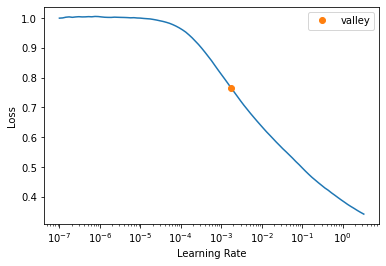

In [37]:
learn.lr_find()

In [38]:
x,y=dls.one_batch()

In [39]:
x,y

(tensor([[0.9190, 1.2508, 0.3897,  ..., 0.0893, 0.4281, 0.5675],
         [0.4096, 0.7940, 1.0046,  ..., 0.3485, 0.1246, 1.4872],
         [0.3765, 0.8951, 0.0374,  ..., 0.0442, 0.0624, 0.2973],
         ...,
         [0.5518, 0.5263, 0.4171,  ..., 0.0123, 0.1158, 0.3744],
         [0.0696, 0.0903, 0.2886,  ..., 0.0501, 0.0655, 0.1880],
         [0.3924, 0.4345, 0.1593,  ..., 0.0920, 0.0724, 0.6734]],
        device='cuda:0'),
 tensor([[-0.0043,  0.0641,  0.0580,  ..., -0.0049,  0.0535,  0.0019],
         [ 0.0529, -0.0192,  0.0191,  ...,  0.1117, -0.0167, -0.0328],
         [ 0.0039,  0.0103, -0.0279,  ...,  0.0883,  0.1122,  0.0870],
         ...,
         [ 0.0529, -0.0192,  0.0191,  ...,  0.1117, -0.0167, -0.0328],
         [-0.0415,  0.0153, -0.0039,  ...,  0.0841, -0.0218,  0.0170],
         [ 0.0652, -0.0031, -0.0474,  ...,  0.0718,  0.0332, -0.0757]],
        device='cuda:0'))

In [40]:
learn.fit_one_cycle(15,3e-2)

epoch,train_loss,valid_loss,time
0,0.079304,0.038789,00:03
1,0.044973,0.038140,00:03
2,0.035411,0.035202,00:03
3,0.033325,0.028660,00:03
4,0.026737,0.026497,00:03
5,0.023268,0.023933,00:03
6,0.020649,0.023801,00:03
7,0.017167,0.024455,00:03
8,0.015429,0.021992,00:03
9,0.012709,0.022449,00:04


In [41]:
learn.model(x).shape

torch.Size([64, 300])

In [42]:
learn.model.eval()
preds = []
with torch.no_grad():
    for x,y in learn.dls.train:
        preds.append(learn.model(x).cpu().numpy())
    for x,y in learn.dls.valid:
        preds.append(learn.model(x).cpu().numpy())

In [43]:
preds = np.concatenate(preds, 0)

<b>Any alternatives to this one? </b>


Looking at predicted tags in image classes

Now we will check, for one given image, what are the word vectors that are the closes to it. To compute this very quickly, we use nmslib which is very fast (pip install nmslib).


In [44]:
!pip install nmslib

In [45]:
import nmslib

def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
     return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=10)

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


We first look in the word vectors of our given classes:

In [47]:
vecs = []
for n in named_classes:
    vecs.append(en_vecs.get_sentence_vector(n.replace('_', ' ')))

In [48]:
nn_classes = create_index(vecs)

In [49]:
valid_preds = preds[-len(learn.dls.valid_ds):]

In [50]:
idxs,dists = get_knns(nn_classes, valid_preds)

In [51]:
dataset.reset_format()

In [52]:
valid_ds=dataset.filter(lambda ex:ex['is_valid'])

  0%|          | 0/14 [00:00<?, ?ba/s]

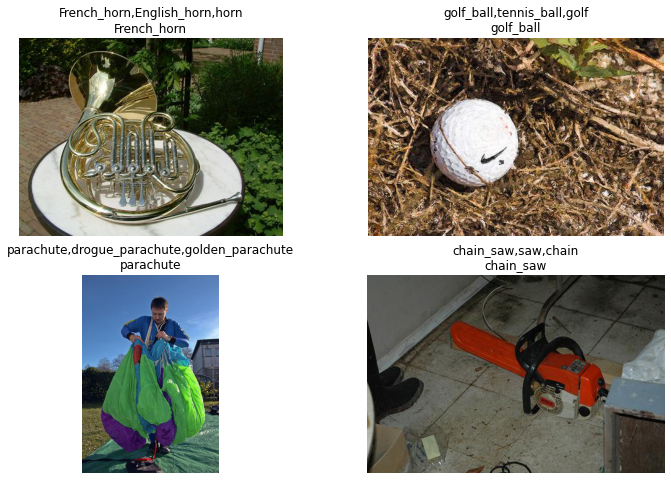

In [53]:
ks = [0,1000,2000,3000]
_,axs = plt.subplots(2,2,figsize=(12,8))
for k,ax in zip(ks, axs.flatten()):
    PILImage.create(valid_ds['images'][k]).show(ax = ax)
    title = ','.join([named_classes[i] for i in idxs[k][:3]])
    l=valid_ds['txt_label'][k]
    title += f'\n{l}'
    ax.set_title(title)

### Looking at predicted tags in all Wordnet

Now let's look at the words it finds in all Wordnet.

In [54]:
words,wn_vecs = [],[]
for k,n in labels.items():
    words.append(n)
    wn_vecs.append(en_vecs.get_sentence_vector(n.replace('_', ' ')))

In [55]:
nn_wvs = create_index(wn_vecs)

In [56]:
idxs,dists = get_knns(nn_wvs, valid_preds)

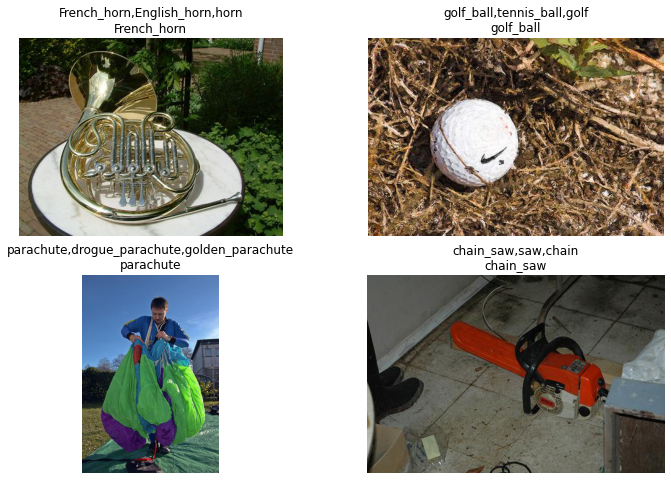

In [57]:
ks = [0,1000,2000,3000]
_,axs = plt.subplots(2,2,figsize=(12,8))
for k,ax in zip(ks, axs.flatten()):
    PILImage.create(valid_ds['images'][k]).show(ax = ax)
    title = ','.join([words[i] for i in idxs[k][:3]])
    l=valid_ds['txt_label'][k]
    title += f'\n{l}'
    ax.set_title(title)

### Text -> Image search

We can use the reverse approach: feed a word vector and find the image activations that match it the closest:

In [58]:
nn_preds = create_index(valid_preds)

In [59]:
def show_imgs_from_text(text):
    vec = en_vecs.get_sentence_vector(text)
    idxs,dists = get_knn(nn_preds, vec)
    _,axs = plt.subplots(2,2,figsize=(12,8))
    for i,ax in zip(idxs[:4], axs.flatten()):
        PILImage.create(valid_ds['images'][i]).show(ax = ax)

'boat' isn't a label in ImageNet, yet if we ask the images whose vord vectors are the most similar to the word vector for boat...

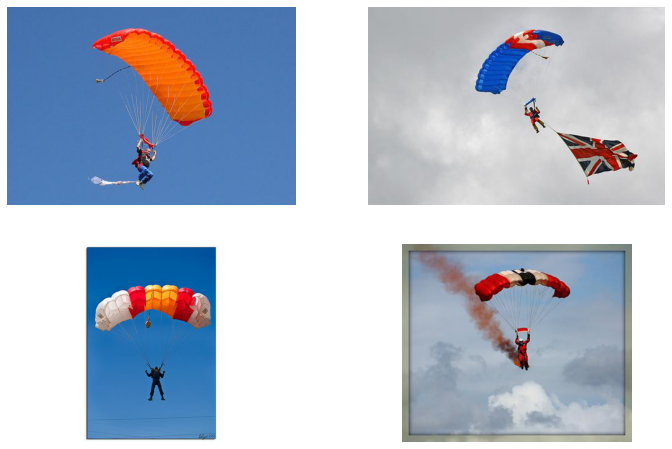

In [92]:
show_imgs_from_text('parachute')

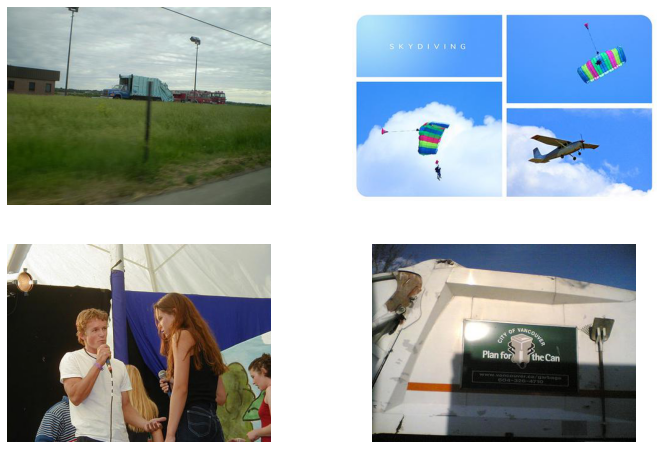

In [61]:
show_imgs_from_text('motor boat')

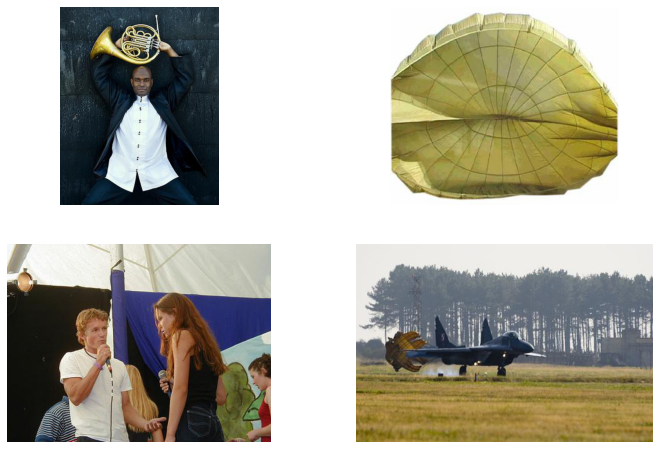

In [62]:
show_imgs_from_text('sail boat')

### Image->image

We can also ask for the images with a word vector most similar to another image. This one was downloaded from Google and isn't in Imagenet.

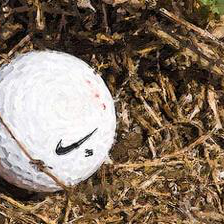

In [116]:
img = PILImage.create(valid_ds['images'][1000])
img = CropPad(224)(img)
img

To get the corresdponding vector, we need to feed it to the pretrained model (body, defined at the top) after normalizing it.

In [117]:
m,s = imagenet_stats
x = (ToTensor()(img)/255 - tensor(m)[:,None,None])/tensor(s)[:,None,None]

In [118]:
m

[0.485, 0.456, 0.406]

In [119]:
activs = model.eval()(x[None].cuda())

In [120]:
activs

TensorImage([[0.3585, 0.9169, 0.7563,  ..., 0.4234, 0.7362, 0.9497]],
       device='cuda:0', grad_fn=<AliasBackward0>)

In [121]:
pred = learn.model.eval()(activs)

In [122]:
pred = pred[0].detach().cpu().numpy()

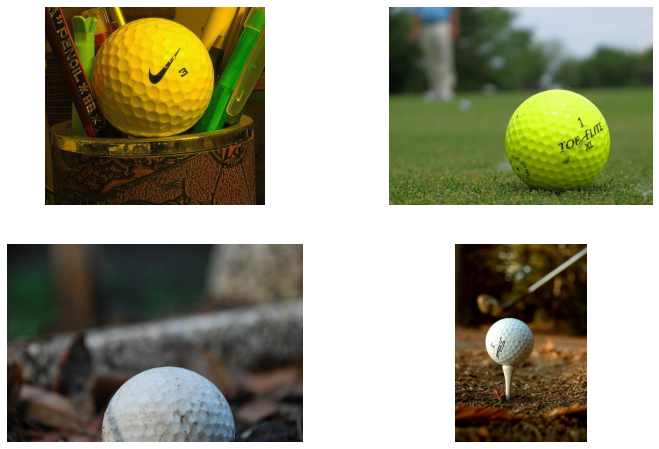

In [123]:
idxs,dists = get_knn(nn_preds, pred)
_,axs = plt.subplots(2,2,figsize=(12,8))
for i,ax in zip(idxs[:4], axs.flatten()):
    PILImage.create(valid_ds['images'][i]).show(ax = ax)

In [109]:
idxs

array([2664, 2674, 2683, 2610, 2237, 2627, 2274, 2554, 2502, 2607],
      dtype=int32)